In [34]:
import os
import torch
import importlib
import data_pre
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")
import code_package.model_package as mcr2_model
import code_package.mcr2_trainer as mcr2_trainer
from code_package import run_code_timer
timer =  run_code_timer.Timer()
import torch.nn as nn

In [54]:
import yaml
params_path = os.path.join('model_params','cmapss_lrd.yaml')
cmapss_lrd_params = yaml.load(open(params_path, 'r'), Loader=yaml.FullLoader)
configs = yaml.load(open('configs/cmapss_mcr2_config.yaml', 'r'), Loader=yaml.FullLoader)
DEVICE  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [57]:
encoder_params = cmapss_lrd_params['encoder_params']
decoder_params = cmapss_lrd_params['decoder_params']
kl_weights = 0.001
DEVICE  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for latent_dim in [1,2,3,4,5]:
    datadir = os.path.join('dataloaders',str(latent_dim), 'cmapss_004.pt')
    data_loader, data_set = torch.load(datadir, map_location=DEVICE)
    timer.start()
    class_dim = latent_dim
    encoder_params['class_dim'] = class_dim
    encoder_params['latent_dim'] = latent_dim
    encoder_params['encoder_activation'] = 'relu'
    decoder_params['class_dim'] = class_dim
    decoder_params['latent_dim'] = latent_dim
    decoder_params['decoder_activation'] = 'relu'
    decoder_params['drop_rate'] = 0.2
    decoder_params['recons_activation'] = None
    decoder_params['decoder_depth'] = 3
    decoder_params['decoder_width'] = [200, 50, 50]
    lambdas = 1e-10
    mcr2 =  mcr2_model.MCR2(encoder_params, decoder_params, is_ts=0, kl_weights=kl_weights)
    mcr2.lambdas = lambdas
    mcr2.to(DEVICE)
    mcr2.device = DEVICE
    base_dir =os.path.join('./latent_dim_selection/', 'latent_dim_'+str(latent_dim))
    configs['pre_train_epoch'] = 200
    configs['n_epoch'] = 50
    configs['save_freq'] = 25
    configs['pre_train_path'] = 'pre_train.pth'
    trainer  = mcr2_trainer.MCR2Trainer(mcr2, data_loader, data_set, configs, base_dir, DEVICE)
    best_overall_model_path = trainer.multi_start_train([1])
    timer.stop()

./latent_dim_selection/latent_dim_1\logs


  4%|▍         | 2/50 [00:06<02:44,  3.42s/it]


KeyboardInterrupt: 

In [58]:
mcr2

MCR2(
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (encoder): MCR2Encoder(
    (encoder): Sequential(
      (layer0): Linear(in_features=17, out_features=50, bias=True)
      (dropout0): Dropout(p=0.0, inplace=False)
      (relu0): ReLU()
      (layer1): Linear(in_features=50, out_features=50, bias=True)
      (dropout1): Dropout(p=0.0, inplace=False)
      (relu1): ReLU()
      (layer2): Linear(in_features=50, out_features=200, bias=True)
      (dropout2): Dropout(p=0.0, inplace=False)
      (relu2): ReLU()
    )
    (direct): Sequential(
      (direct): Linear(in_features=200, out_features=1, bias=True)
    )
    (cov_vec_layer): Sequential(
      (cl): Linear(in_features=200, out_features=1, bias=True)
      (c_ac): Sigmoid()
    )
    (mu_layer): Sequential(
      (ml): Linear(in_features=200, out_features=1, bias=True)
      (m_ac): Sigmoid()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (layer0): Linear(in_features=4, out_features=200, bias=True)
     

In [42]:
# check 
import numpy as np
# 计算model的AIC， BIC
def count_parameters(model):
    """
    计算 PyTorch 模型的参数数量

    参数:
    model (nn.Module): PyTorch 模型

    返回:
    total_params (int): 模型的总参数数量
    """
    model_params = sum(p.numel() for p in model.parameters())
    gmm_params = model.class_dim * (model.latent_dim + 1) * model.latent_dim
    total_params = model_params + gmm_params
    return total_params, model_params, gmm_params

def calculate_aic_bic(log_likelihood, n_samples, n_params):
    """
    计算AIC和BIC

    参数:
    log_likelihood (float): 模型的对数似然值
    n_samples (int): 训练数据的样本数量
    n_params (int): 模型的总参数数量

    返回:
    aic (float): 计算得到的AIC值
    bic (float): 计算得到的BIC值
    """
    # 计算AIC
    aic = -2 * log_likelihood + 2 * n_params
    
    # 计算BIC
    bic = -2 * log_likelihood + np.log(n_samples) * n_params
    
    return aic, bic

In [80]:
def cal_aic_bic(latent_dim):
    datadir = os.path.join('dataloaders',str(latent_dim), 'cmapss_004.pt')
    data_loader, data_set = torch.load(datadir, map_location=DEVICE)
    base_folder = './test_latent_selection/'
    dim_folder = 'latent_dim_'+str(latent_dim)
    path = os.path.join(base_folder, dim_folder)
    model_path = os.path.join(path, 'models')
    ls = os.listdir(model_path)
    ls.sort()
    best_start = '1'#ls[-1][-5]
    best_start_model_path = os.path.join(model_path, best_start, 'best_model.pth')
    class_dim = latent_dim
    encoder_params['class_dim'] = class_dim
    encoder_params['latent_dim'] = latent_dim
    decoder_params['class_dim'] = class_dim
    decoder_params['latent_dim'] = latent_dim
    decoder_params['recons_activation'] = None
    lambdas = 1e-10
    mcr2 =  mcr2_model.MCR2(encoder_params, decoder_params, is_ts=0, kl_weights=kl_weights)
    mcr2.load_state_dict(torch.load(best_start_model_path, map_location=DEVICE)[0])
    mcr2.lambdas = lambdas
    mcr2.to(DEVICE)
    mcr2.device = DEVICE
    #random.seed(0)
    torch.manual_seed(0)
    with torch.no_grad():
        res = mcr2(data_set['train'][0], data_set['train'][1], data_set['train'][2])
    loss_res = mcr2.loss_function(res, data_set['train'][0])
    total_params, model_params, gmm_params = count_parameters(mcr2)
    n_samples = len(data_set['train'][0])
    log_likelihood = -(loss_res['recons_loss'])*n_samples/2
    print(total_params, model_params, gmm_params, log_likelihood, n_samples)
    n_params = gmm_params
    aic, bic = calculate_aic_bic(log_likelihood, n_samples, n_params)
    print(aic, bic)
    return aic, bic

In [81]:
model_selection_dict = {}
encoder_params = cmapss_lrd_params['encoder_params']
decoder_params = cmapss_lrd_params['decoder_params']
kl_weights = 0.001
for latent_dim in range(1, 6):
    aic, bic = cal_aic_bic(latent_dim)
    model_selection_dict[latent_dim] = [aic, bic]

28572 28570 2 tensor(-4707.3735, device='cuda:0') 30624
tensor(9418.7471, device='cuda:0') tensor(9435.4062, device='cuda:0')
28994 28982 12 tensor(-3319.2727, device='cuda:0') 30624
tensor(6662.5454, device='cuda:0') tensor(6762.5000, device='cuda:0')
29444 29408 36 tensor(-2901.2590, device='cuda:0') 30624
tensor(5874.5181, device='cuda:0') tensor(6174.3813, device='cuda:0')
29934 29854 80 tensor(-2708.7249, device='cuda:0') 30624
tensor(5577.4497, device='cuda:0') tensor(6243.8130, device='cuda:0')
30476 30326 150 tensor(-2459.4619, device='cuda:0') 30624
tensor(5218.9238, device='cuda:0') tensor(6468.3545, device='cuda:0')


In [87]:
import pandas as pd
pd.DataFrame(bic_values)

,0
0,9435.406250
1,6762.500000
2,6174.381348
3,6243.812988
4,6468.354492


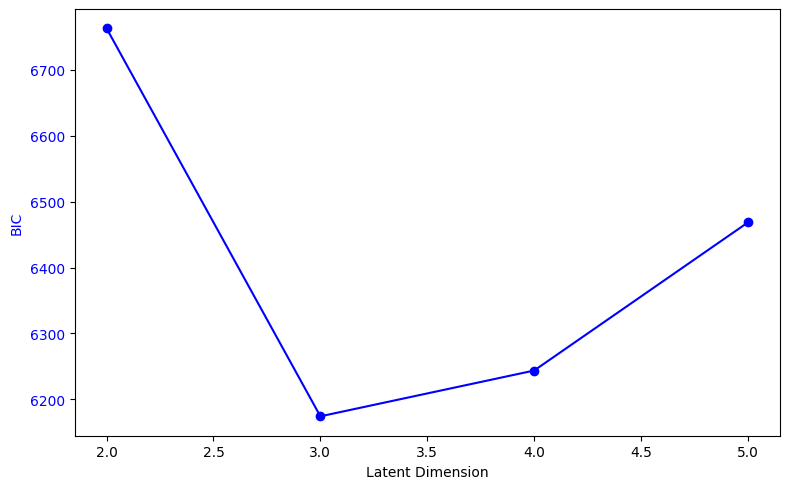

In [83]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(8, 5))

# 横轴为 latent_dim
latent_dims = list(model_selection_dict.keys())
aic_values = [model_selection_dict[dim][0].item() for dim in latent_dims]
bic_values = [model_selection_dict[dim][1].item() for dim in latent_dims]

'''
# 绘制 AIC 曲线
ax1.plot(latent_dims, aic_values, 'b-o', label='AIC')
ax1.set_xlabel('Latent Dimension')
ax1.set_ylabel('AIC', color='b')
ax1.tick_params(axis='y', labelcolor='b')
'''

# 创建第二个 y 轴
ax2 = ax1#.twinx()
ax2.plot(latent_dims[1:], bic_values[1:], 'b-o', label='BIC')
ax2.set_ylabel('BIC', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_xlabel('Latent Dimension')
# 添加图例
#fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

#plt.title('Model Selection: BIC vs Latent Dimension')
plt.tight_layout()
plt.show()